## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import os

### Read data into DFs

In [2]:
headers = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','pred']

In [3]:
original_train_df = pd.read_csv("census-income.data.csv", low_memory = False, names = headers, index_col = False)

In [4]:
original_test_df = pd.read_csv("census-income.test.csv", low_memory = False, names = headers, index_col = False)

In [5]:
original_train_df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
pred              0
dtype: int64

In [6]:
original_train_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
pred              0
dtype: int64

In [7]:
train_df = original_train_df.copy()

In [8]:
test_df = original_test_df.copy()

In [9]:
train_df[:25]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Cleanup:

# To Do's:

**Duplicate Data**
* Check for duplicates

We only found ~34 duplicated values, but they don't even actually appear to be duplicated - only one looks like a duplicate to me.

**Missing Values**
* Find missing values
    * I've found the "?" missing values so far
* Deal with missing values

**Imbalanced Data**
* Deal with imbalanced data

**OneHotEncoding**
* Convert categorical values into a Category datatype using OneHotEncoder
* Analyze charts to find patterns

In [41]:
train_df['pred'].value_counts()

pred
<=50K    24720
>50K      7841
Name: count, dtype: int64

### Remove whitespace

In [10]:
# show example value

train_df.iloc[0]['occupation']

' Adm-clerical'

In [11]:
def data_to_str(df):

# Iterate through dataframe, test datatype, append string-type columns into our list,
# use list to strip whitespace from string values in columns
    
    to_string_list = [] # create empty list to fill with string-dtype column names
    
    for col in df: # iterate through all columns in train_df
        if pd.api.types.is_object_dtype(df[col]): # test if string-datatype
            to_string_list.append(col) # if true, append to list
    
    for col in to_string_list: # iterate through list of string-datatype columns
        df[col] = df[col].str.strip() # strip all values in column of whitespace

In [12]:
data_to_str(train_df)

In [13]:
# test example value

train_df.iloc[0]['occupation']

'Adm-clerical'

### Explicitly declare int32 datatype

In [14]:
# The integers are stored in int64 - not wrong, but unnecessarily large for these values

train_df.iloc[0]['age']

np.int64(39)

In [15]:
def data_to_int32(df):

# Iterate through dataframe, test datatype, append numeric-type columns into our list,
# use list to strip whitespace from numeric values in columns

    to_int32_list = [] # create empty list to fill with numeric-dtype column names
    
    for col in df: # iterate through all columns in train_df
        if pd.api.types.is_numeric_dtype(df[col]): # test if string-datatype
            to_int32_list.append(col) # if true, append to list
    
    for col in to_int32_list: # iterate through list of string-datatype columns
        df[col] = df[col].astype('int32') # strip all values in column of whitespace

In [16]:
data_to_int32(train_df)

In [17]:
train_df.iloc[0]['age']

np.int32(39)

In [18]:
train_df.dtypes

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
pred              object
dtype: object

In [19]:
train_df.replace("?", pd.NA, inplace=True)

In [20]:
train_df[train_df.isna().any(axis=1)]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,<NA>,>50K
27,54,<NA>,180211,Some-college,10,Married-civ-spouse,<NA>,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,<NA>,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,<NA>,<=50K
61,32,<NA>,293936,7th-8th,4,Married-spouse-absent,<NA>,Not-in-family,White,Male,0,0,40,<NA>,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,<NA>,320084,Bachelors,13,Married-civ-spouse,<NA>,Wife,White,Female,0,0,55,United-States,>50K
32531,30,<NA>,33811,Bachelors,13,Never-married,<NA>,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32539,71,<NA>,287372,Doctorate,16,Married-civ-spouse,<NA>,Husband,White,Male,0,0,10,United-States,>50K
32541,41,<NA>,202822,HS-grad,9,Separated,<NA>,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [36]:
train_df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', <NA>, 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [38]:
train_df['relationship'].unique()

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [21]:
train_df['native-country'].value_counts(dropna=False)

native-country
United-States                 29170
Mexico                          643
<NA>                            583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France       

In [46]:
train_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [49]:
duplicates = train_df.duplicated()
train_df[duplicates].sort_values('fnlwgt')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
28846,39,Private,30916,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
21875,49,Private,31267,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
22494,49,Self-emp-not-inc,43479,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
30845,46,Private,133616,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
18555,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,<NA>,<=50K
21490,19,Private,146679,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K


In [22]:
bar_charts = ['sex','race','workclass','marital-status','occupation','relationship','education','education-num','native-country']

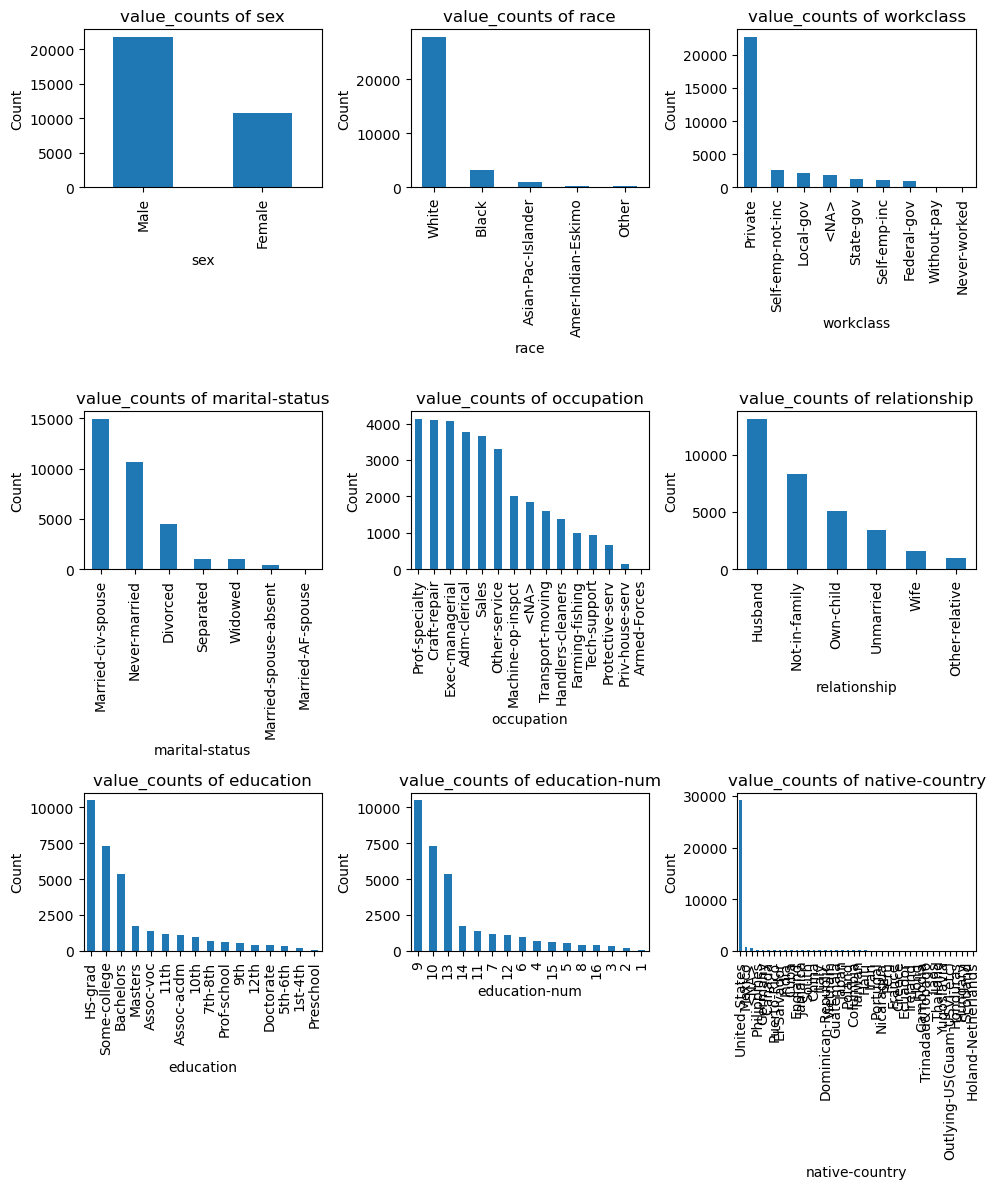

In [26]:
# Number of columns & rows
cols = 3
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))

axes = axes.flatten()   # flatten array of axes for easy indexing

for i, column in enumerate(bar_charts):
    train_df[column].value_counts(dropna=False).plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"value_counts of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [24]:
hist_charts = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

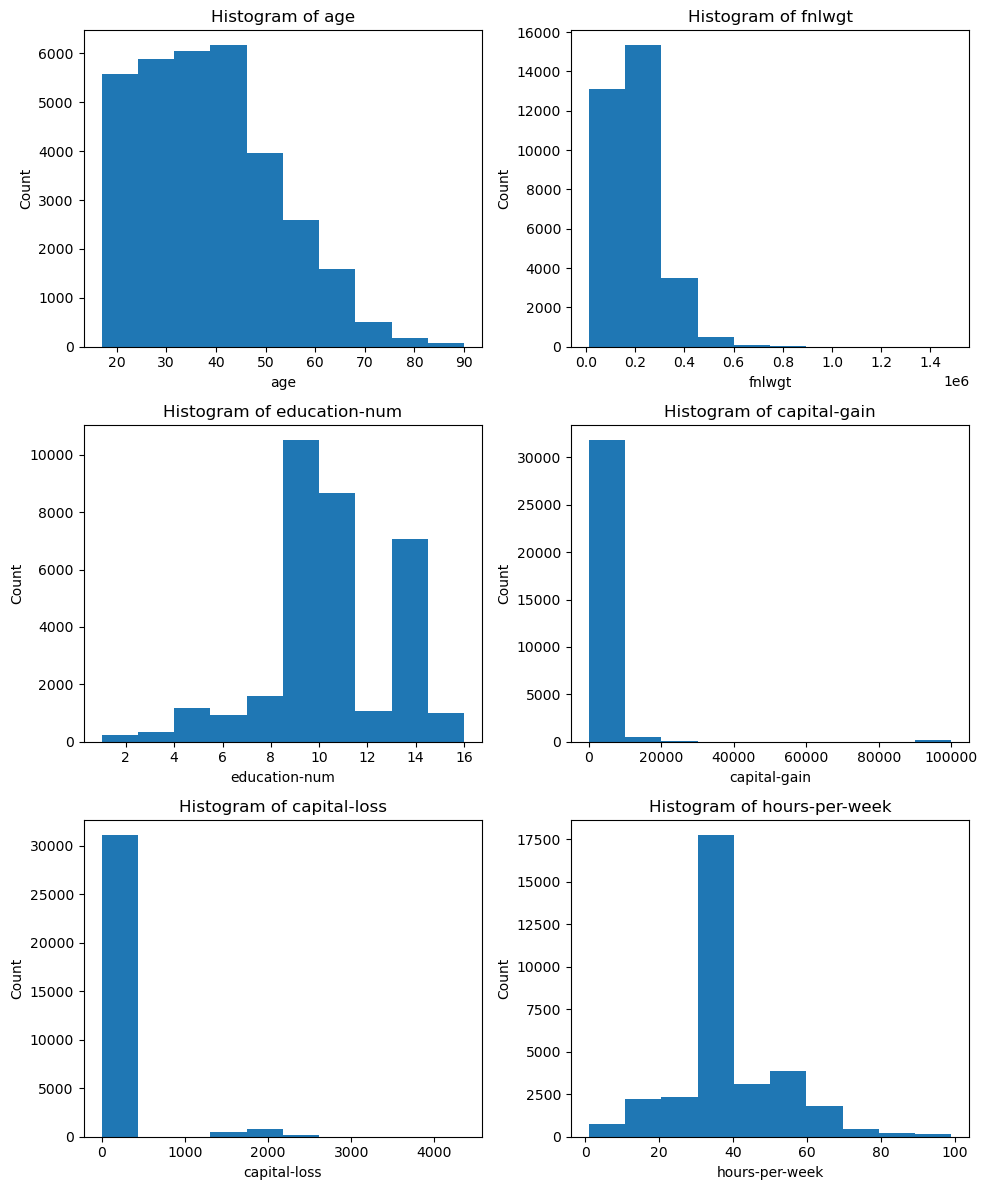

In [35]:
# Number of columns & rows
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))

axes = axes.flatten()   # flatten array of axes for easy indexing

for i, column in enumerate(hist_charts):
    train_df[column].plot(kind='hist', ax=axes[i])
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int32 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int32 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int32 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int32 
 11  capital-loss    32561 non-null  int32 
 12  hours-per-week  32561 non-null  int32 
 13  native-country  31978 non-null  object
 14  pred            32561 non-null  object
dtypes: int32(6), object(9)
memory usage: 3.0+ MB


In [ ]:
train_df.drop('pred', axis=1)

In [ ]:
'''
corr_matrix = train_df.drop('pred', axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots()
heatmap = sns.heatmap(corr_matrix, cmap='RdBu', linewidths=1, fmt=".1%", annot_kws={"color": "darkgrey", "size": 12}, mask=mask)
plt.figure(figsize=(15,15))
ax.set_title('Correlation Matrix')
plt.show()
'''

In [ ]:
train_df.value_counts(['race','sex'])

In [ ]:
train_df.value_counts(['occupation'])